Reference video: https://www.youtube.com/watch?v=Oh1AiiPpoTo

In [1]:
import numpy as np
import numba as nb
import sympy as sp
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib import animation
plt.style.use('dark_background')

tau = 2 * np.pi

In [2]:
import sys
sys.path.append('../')

In [3]:
from modules.visualize import plot_complex

## Getting fourier coeffs using series inversion

In [4]:
def expand_recursive_eq(n):
    z, c = sp.symbols('z c')
    recursive_eq = z**2 + c
    z_c = 0
    for _ in range(n):
        z_c = recursive_eq.subs(z, z_c)
    z_c = sp.expand(z_c)
    # Take the root of the highest degree.
    z_c = sp.root(z_c, 2**(n-1))
    return z_c

n = 2
z_n = expand_recursive_eq(n)
z_n

sqrt(c**2 + c)

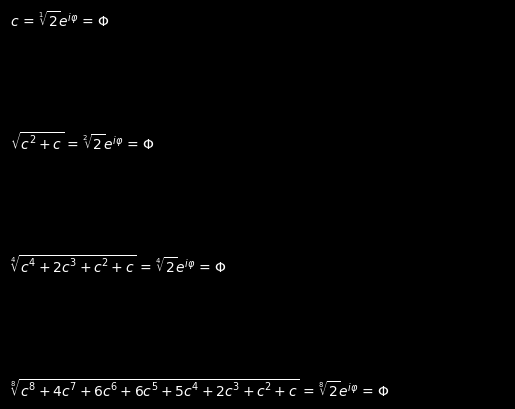

In [5]:
n = 4
for i, y in zip(range(1, n+1), np.linspace(1,0,n)):
  z_n = expand_recursive_eq(i)
  pow = 2**(i-1)
  lhs = fr'${sp.latex(z_n)}$'
  rhs = fr'$\sqrt[{pow}]{{2}} e^{{i\varphi}}$'
  plt.text(0, y, f'{lhs} = {rhs} = $\\Phi$')
plt.axis('off')
plt.show()

$\Phi$ expressed as $f(c)$

In [7]:
series = sp.series(z_n, x0=sp.oo, n=6).removeO()
series

c + 1/2 - 1/(8*c) + 5/(16*c**2) - 53/(128*c**3) + 127/(256*c**4) - 677/(1024*c**5)

If you can revert this series to express $c$ as $f(\Phi)$ then the coefficients of that series would be the fourier coeffs.$

I can't seem to find a way in python to invert a sympy series, the code below gets stuck. \
So I have set its cell type to `Raw` to prevent it from being executed.

## Computing fourier coeffs directly

Using Jungreis function \
Reference: "The area of the Mandelbrot set” by John H. Ewing & Glenn Schober (Numer. Math. 61 (1992) 59–72)

In [54]:
# source reference: https://gist.github.com/Gro-Tsen/4c5434b23c5a7e95e9c1cab345cdbf5f
target = 2**13 + 1
sizen = int(np.ceil(np.log2(target + 4)))

@nb.njit
def get_betatab(target, sizen):
    betatab = np.zeros((target + 1, sizen))
    for m in range(target + 1):
        if m == 0:
            betatab[m, :] = [1 if n == 0 else np.nan for n in range(sizen)]
        else:
            subtab = np.zeros(sizen)
            subtab[sizen - 1] = 0
            for n in range(sizen - 1, 0, -1):
                if m >= 2**n - 1:
                    sum_val = 0
                    for k in range(2**n - 1, m - 2**n + 2):
                        sum_val += betatab[k, n - 1] * betatab[m - k, n - 1]
                    subtab[n - 1] = (subtab[n] - sum_val - betatab[m - 2**n + 1, 0]) / 2
                else:
                    subtab[n - 1] = 0
            betatab[m, :] = subtab
    return betatab

betatab = get_betatab(target, sizen)
coeffs = np.array([betatab[m][0] for m in range(target)])

In [55]:
def inv_DFT(X, num_samples=None):
  if num_samples is None:
    num_samples = len(X)
  k, n = np.arange(len(X)), np.linspace(0, 1, num_samples)
  return np.dot(X, np.exp(1j * tau * (k - 1) * n[:, None]).T)

num_samples = 20000
points = inv_DFT(coeffs, num_samples)

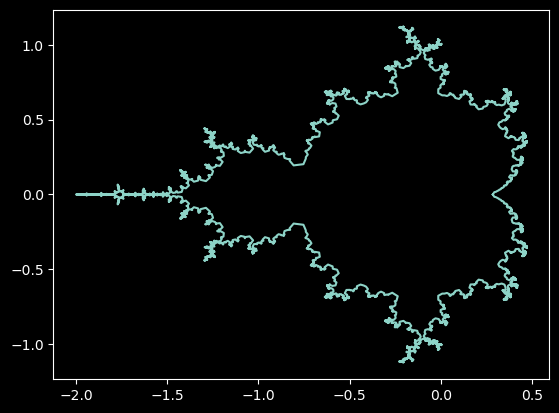

In [56]:
plot_complex(points)

### Evolution (Coeff progression)

In [57]:
from modules.visualize import evolution_animate

In [58]:
def compute_apprs(coeffs, num_samples, coeffs_seq=None):
  num_coeffs = len(coeffs)
  if coeffs_seq is None:
    coeffs_seq = 1 + np.arange(len(coeffs), dtype=int)
  points_apprs = {}
  for n in tqdm(coeffs_seq, desc='calculating approximations'):
    points_apprs[n] = inv_DFT(coeffs[:n], num_samples)
  return points_apprs

# coeffs_seq = np.linspace(1, len(coeffs), 100).astype(int)
coeffs_seq = np.geomspace(1, len(coeffs), 500).astype(int)
points_apprs = compute_apprs(coeffs, num_samples, coeffs_seq)

calculating approximations:   0%|          | 0/500 [00:00<?, ?it/s]

In [59]:
points_apprs_array = np.array(list(map(lambda x: np.array(list(x)), points_apprs.values()) ))

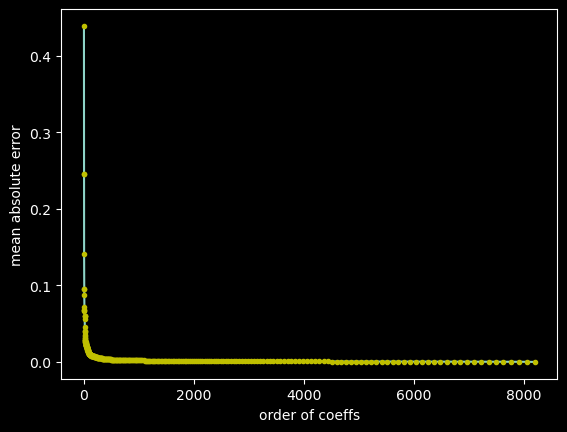

In [60]:
errs = np.log(1+abs(points - points_apprs_array).mean(1))
plt.plot(points_apprs.keys(), errs, marker='o', ms=3, mfc='y', mec='y')
plt.xlabel('order of coeffs')
plt.ylabel('mean absolute error')
plt.show()

In [65]:
anim = evolution_animate(points_apprs)
FFwriter = animation.FFMpegWriter(fps=10)
anim.save('../animations/evolution.gif', writer=animation.PillowWriter(fps=10))

# For colab.
# anim.save(f'../animations/evolution.mp4', writer=FFwriter, dpi=300)

generating evolution animation:   0%|          | 0/332 [00:00<?, ?it/s]